In [17]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8")

import joblib

In [18]:
df = pd.read_csv("/Users/nicki/PortoProjek/lloyds-customer-churn-prediction/data/processed/cleaned_customer_churn_data.csv")

print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (1000, 22)
        Age TransactionDate  AmountSpent InteractionDate LastLoginDate  \
0  1.229628      2022-03-27     1.154712      2022-03-31    2023-10-21   
1  1.426547      2022-08-08    -1.397890      2022-03-17    2023-12-05   
2 -1.658518      2022-07-25    -0.391506      2022-08-24    2023-11-15   
3 -1.461599      2022-01-25    -1.070642      2022-11-18    2023-08-25   
4 -1.461599      2022-07-24     1.019647      2022-07-03    2023-10-27   

   LoginFrequency  Gender_M  MaritalStatus_Married  MaritalStatus_Single  \
0        0.575702       1.0                    0.0                   1.0   
1       -1.488513       1.0                    1.0                   0.0   
2       -1.630872       1.0                    0.0                   1.0   
3       -1.702052       1.0                    0.0                   0.0   
4        1.073961       1.0                    0.0                   0.0   

   MaritalStatus_Widowed  ...  ProductCategory_Clothing  \
0            

In [19]:
print(df.columns.tolist())


['Age', 'TransactionDate', 'AmountSpent', 'InteractionDate', 'LastLoginDate', 'LoginFrequency', 'Gender_M', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widowed', 'IncomeLevel_Low', 'IncomeLevel_Medium', 'ProductCategory_Clothing', 'ProductCategory_Electronics', 'ProductCategory_Furniture', 'ProductCategory_Groceries', 'InteractionType_Feedback', 'InteractionType_Inquiry', 'ResolutionStatus_Unresolved', 'ServiceUsage_Online Banking', 'ServiceUsage_Website', 'ChurnStatus']


In [22]:
# KONVERSI TANGGAL to NUMERIC
date_cols = ['TransactionDate', 'InteractionDate', 'LastLoginDate']

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = df[col].astype('int64') // 10**9     # convert to UNIX timestamp 

# DEFINISIKAN FEATURES & TARGET

features = [
    'Age', 'TransactionDate', 'AmountSpent', 'InteractionDate', 'LastLoginDate',
    'LoginFrequency', 'Gender_M', 'MaritalStatus_Married',
    'MaritalStatus_Single', 'MaritalStatus_Widowed',
    'IncomeLevel_Low', 'IncomeLevel_Medium',
    'ProductCategory_Clothing', 'ProductCategory_Electronics',
    'ProductCategory_Furniture', 'ProductCategory_Groceries',
    'InteractionType_Feedback', 'InteractionType_Inquiry',
    'ResolutionStatus_Unresolved', 'ServiceUsage_Online Banking',
    'ServiceUsage_Website'
]

target = "ChurnStatus"

X = df[features]
y = df[target]


In [23]:
# TRAIN-TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



In [24]:
# RANDOM FOREST
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]


# XGBOOST
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)

xgb_preds = xgb.predict(X_test)
xgb_probs = xgb.predict_proba(X_test)[:, 1]




Random Forest
Accuracy : 0.78
Precision: 0.3333333333333333
Recall   : 0.07317073170731707
F1-score : 0.12
ROC-AUC  : 0.5140358950759318

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.96      0.87       159
         1.0       0.33      0.07      0.12        41

    accuracy                           0.78       200
   macro avg       0.57      0.52      0.50       200
weighted avg       0.71      0.78      0.72       200


XGBoost
Accuracy : 0.77
Precision: 0.3076923076923077
Recall   : 0.0975609756097561
F1-score : 0.14814814814814814
ROC-AUC  : 0.4644884184690904

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.94      0.87       159
         1.0       0.31      0.10      0.15        41

    accuracy                           0.77       200
   macro avg       0.55      0.52      0.51       200
weighted avg       0.70      0.77      0.72       200



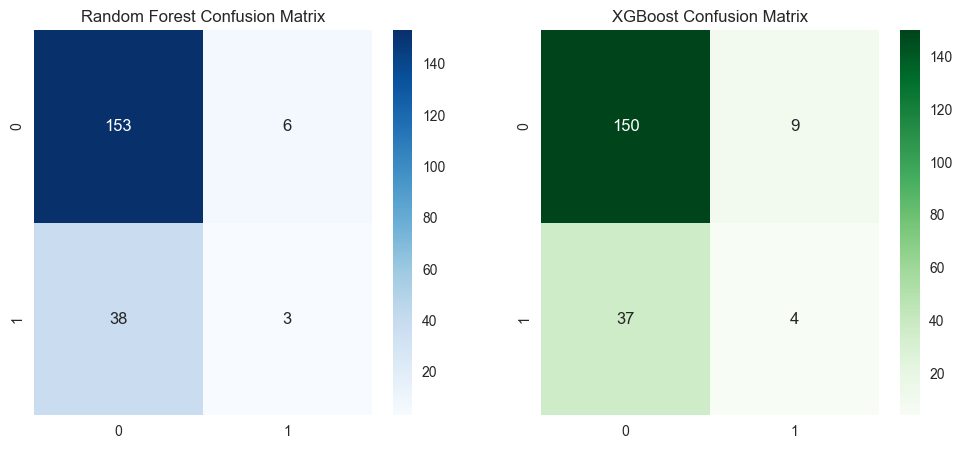

In [30]:
# EVALUATION FUNCTION

def evaluate(name, y_test, preds, probs):
    print(f"\n{name}")
    print("Accuracy :", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds))
    print("Recall   :", recall_score(y_test, preds))
    print("F1-score :", f1_score(y_test, preds))
    print("ROC-AUC  :", roc_auc_score(y_test, probs))
    print("\nClassification Report:")
    print(classification_report(y_test, preds))

# SHOW RESULTS

evaluate("Random Forest", y_test, rf_preds, rf_probs)
evaluate("XGBoost", y_test, xgb_preds, xgb_probs)

# CONFUSION MATRIX

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Random Forest Confusion Matrix")

sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title("XGBoost Confusion Matrix")

plt.show()

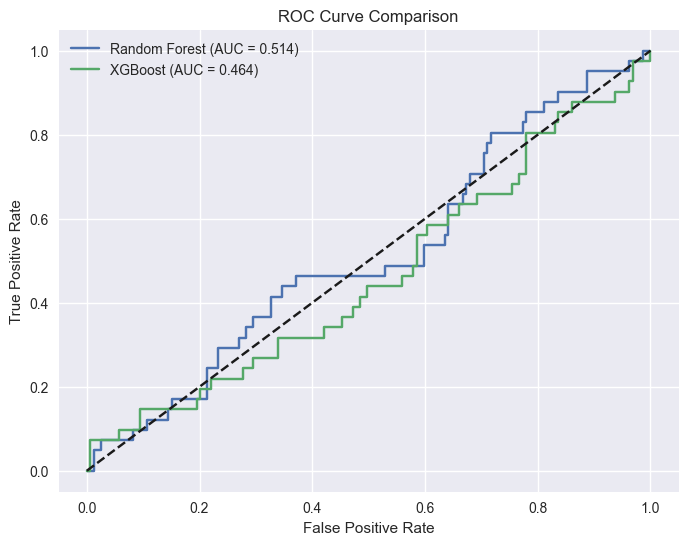

In [27]:
#ROC Curve 

from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.3f})")

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.3f})")

plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


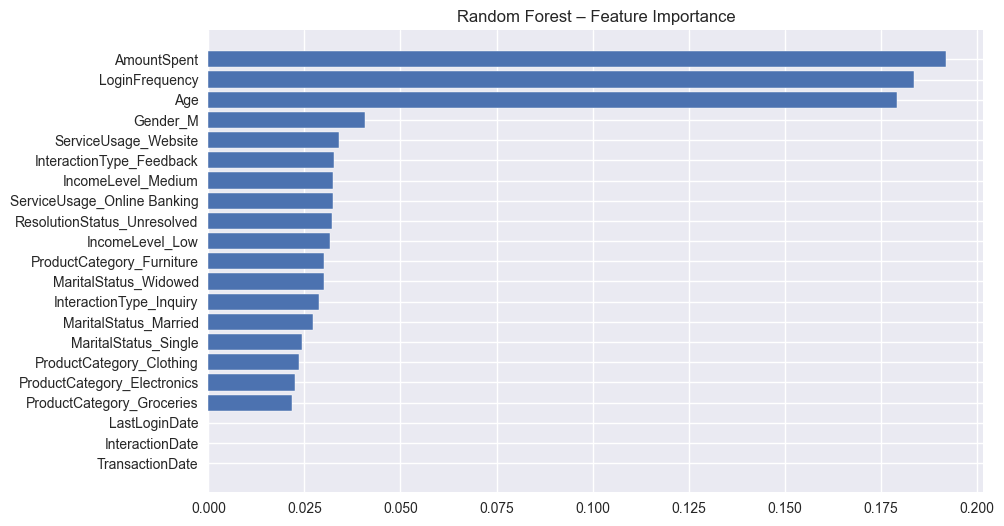

In [28]:
#Feature Importance
importances_rf = rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10,6))
plt.barh(np.array(features)[indices_rf], importances_rf[indices_rf])
plt.title("Random Forest – Feature Importance")
plt.gca().invert_yaxis()
plt.show()


In [29]:
#Model Comparison Table
results = {
    "Model": ["Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, xgb_preds),
    ],
    "Precision": [
        precision_score(y_test, rf_preds),
        precision_score(y_test, xgb_preds),
    ],
    "Recall": [
        recall_score(y_test, rf_preds),
        recall_score(y_test, xgb_preds),
    ],
    "F1 Score": [
        f1_score(y_test, rf_preds),
        f1_score(y_test, xgb_preds),
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, rf_probs),
        roc_auc_score(y_test, xgb_probs),
    ]
}

comparison_df = pd.DataFrame(results)
comparison_df


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Random Forest,0.78,0.333333,0.073171,0.120000,0.514036
1,XGBoost,0.77,0.307692,0.097561,0.148148,0.464488
